**Import necessary libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

**Inputs**

In [2]:
T = 0.527 # Initial period [s]
ksi = 0.003 # Linear damping coeff. 
alpha = 0 # Post-yield stiffness ratio
fy_over_m = 9.955 #Yield pseudo-acc. [m/s2]
theta = 0 # Stability coeff

**Load El-Centro 1940 Imperial Valley Seismic Data**

In [3]:
GroundAccel = pd.read_csv("El-Centro-2.txt", delimiter='\s+') # time [t] vs. g
GroundAccel["ug_ddot"] *= 1 # [m/s2]
GroundAccel["ug_ddot"] *= 9.81 # [m/s2]
GroundAccel.head(3) # Display first 3 rows to check the data

,t,ug_ddot
0,0.000,0.014715
1,0.005,0.020601
2,0.010,0.052974


**Plot the ground acceleration data**

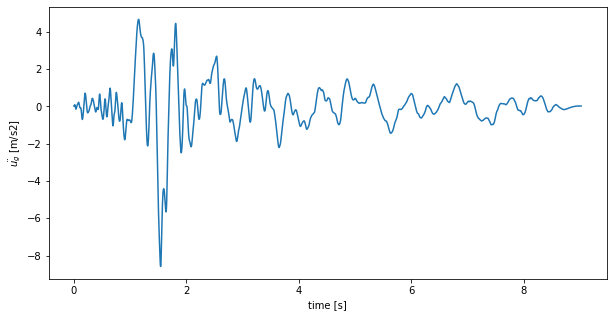

In [4]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(GroundAccel["t"], GroundAccel["ug_ddot"])
ax.set_xlabel("time [s]")
ax.set_ylabel("$\ddot{u_g}$ [m/s2]")
plt.show()

**A function to obtain recurrence coeff. (Aydınoğlu, 2003)**

In [5]:
def recurr_coeff(beta_ej, ksi, omega, deltat):
    if (abs(beta_ej)<1e-10):
        if (abs(ksi)<1e-10):
            A11 = 1
            A12 = deltat
            A21 = 0
            A22 = 1
            B11 = -(1./2.)*deltat**2
            B12 = -(1./6.)*deltat**2
            B21 = -A12
            B22 = B11/delta
            return [A11, A12, A21, A22, B11, B12, B21, B22]
        else:
            eta = 2*ksi*omega
            G = math.exp(-eta*deltat)
            A11 = 1
            A12 = (1-G)/eta
            A21 = 0
            A22 = G
            B11 = (A12-deltat)/eta
            B12 = -(B11/deltat+0.5*deltat)/eta
            B21 = -A12
            B22 = B11/deltat
            return [A11, A12, A21, A22, B11, B12, B21, B22]
    else:
        if (abs(beta_ej-ksi**2)<1e-10):
            A11 = (1+ksi*omega*deltat)*math.exp(-ksi*omega*deltat)
            A12 = deltat*math.exp(-ksi*omega*deltat)
            A21 = -beta_ej*(omega**2)*A12
            A22 = (1-ksi*omega*deltat)*math.exp(-ksi*omega*deltat)
        else:
            if (beta_ej>ksi**2):
                omegaD = omega*(beta_ej-ksi**2)**0.5
                E = math.cos(omegaD*deltat)*math.exp(-ksi*omega*deltat)
                F = math.sin(omegaD*deltat)*math.exp(-ksi*omega*deltat)
            else:
                omegaD = omega*(-beta_ej+ksi**2)**0.5
                E = math.cosh(omegaD*deltat)*math.exp(-ksi*omega*deltat)
                F = math.sinh(omegaD*deltat)*math.exp(-ksi*omega*deltat)
            A11 = E+(ksi*omega/omegaD)*F
            A12 = F/omegaD
            A21 = -beta_ej*(omega**2)*A12
            A22 = E-(ksi*omega/omegaD)*F
        B11 = (A11-1)/(beta_ej*omega**2)
        B12 = (A12-2*ksi*omega*B11-deltat)/(beta_ej*(omega**2)*deltat)
        B21 = -A12
        B22 = B11/deltat
        return [A11, A12, A21, A22, B11, B12, B21, B22]  

**Define initial-conditions and make pre-calculations prior to time stepping**

In [6]:
omega = 2*math.pi/T # Initial natural freq.
deltat = T/1000 # time step
tend = 9.02 # End time of simulation

beta_ej_elastic = 1-theta # Effective stiffness ratio for elastic segments
beta_ej_yielding = alpha-theta # Effective stiffness ratio for yielding segments

u = 0 # Initial displacement
u_dot = 0 # Initial velocity
fs_over_m = 0 # Initial pseudo-acc.
t = 0 # Initial time
mode = "elastic" # Starting mode - elastic or yielding
beta_ej = beta_ej_elastic
ug_ddot = np.interp(0, GroundAccel["t"], GroundAccel["ug_ddot"]) # Ground accel at t=0
uG_ddot = ug_ddot+fs_over_m-beta_ej*(omega**2)*u

# Initiate arrays to store data for post-processing
u_arr = [u]
u_dot_arr = [u_dot]
fs_over_m_arr = [fs_over_m]
t_arr = [t]
ug_ddot_arr = [ug_ddot]
u_ddot_arr = [0]

deltat_ref = deltat

**Perform the time stepping**

In [7]:
while (t<tend):
    
    t += deltat
    
    ug_ddot_old = ug_ddot
    ug_ddot = np.interp(t, GroundAccel["t"], GroundAccel["ug_ddot"])
    delta_ug_ddot = ug_ddot-ug_ddot_old
    
    u_old = u
    u_dot_old = u_dot
    fs_over_m_old = fs_over_m
    
    if (mode == "elastic"):
        AB = recurr_coeff(beta_ej, ksi, omega, deltat)
        u = AB[0]*u_old+AB[1]*u_dot_old+AB[4]*uG_ddot+AB[5]*delta_ug_ddot
        u_dot = AB[2]*u_old+AB[3]*u_dot_old+AB[6]*uG_ddot+AB[7]*delta_ug_ddot
        
        fs_over_m += beta_ej*(omega**2)*(u-u_old)
        
        if (abs(fs_over_m)>fy_over_m):
            if (abs(fs_over_m-fy_over_m)<1e-10 or abs(fs_over_m+fy_over_m)<1e-10):
                mode = "yielding"
                beta_ej = beta_ej_yielding
                deltat = deltat_ref
            else:
                u = u_old
                u_dot = u_dot_old
                ug_ddot = ug_ddot_old
                fs_over_m = fs_over_m_old
                t -= deltat
                deltat *= 0.5
                continue
                           
    elif (mode == "yielding"): 
        AB = recurr_coeff(beta_ej, ksi, omega, deltat)
        u = AB[0]*u_old+AB[1]*u_dot_old+AB[4]*uG_ddot+AB[5]*delta_ug_ddot
        u_dot = AB[2]*u_old+AB[3]*u_dot_old+AB[6]*uG_ddot+AB[7]*delta_ug_ddot
        
        fs_over_m += beta_ej*(omega**2)*(u-u_old)
        
        if ((u_dot>0 and u_dot_old<0) or (u_dot<0 and u_dot_old>0)):
            if abs(u_dot)<1e-10:
                mode = "elastic"
                beta_ej = beta_ej_elastic
                deltat = deltat_ref
            else:
                u = u_old
                u_dot = u_dot_old
                ug_ddot = ug_ddot_old
                fs_over_m = fs_over_m_old
                t -= deltat
                deltat *= 0.5
                continue               
            
    uG_ddot = ug_ddot+fs_over_m-beta_ej*(omega**2)*u
                        
    u_arr.append(u*1000)
    fs_over_m_arr.append(fs_over_m)
    t_arr.append(t)
    ug_ddot_arr.append(ug_ddot)
    u_dot_arr.append(u_dot)
    u_ddot_arr.append((u_dot-u_dot_old)/deltat)

**Post-process**

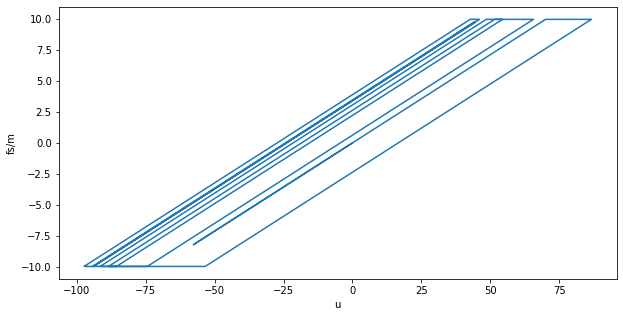

In [8]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(u_arr, fs_over_m_arr)
ax.set_xlabel("u")
ax.set_ylabel("fs/m")
plt.show()

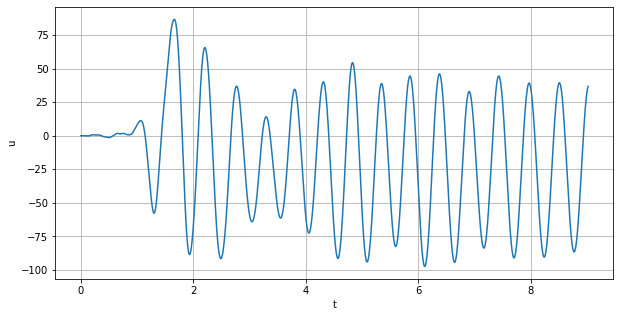

In [9]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(t_arr, u_arr)
ax.set_xlabel("t")
ax.set_ylabel("u")
ax.grid()
plt.show()

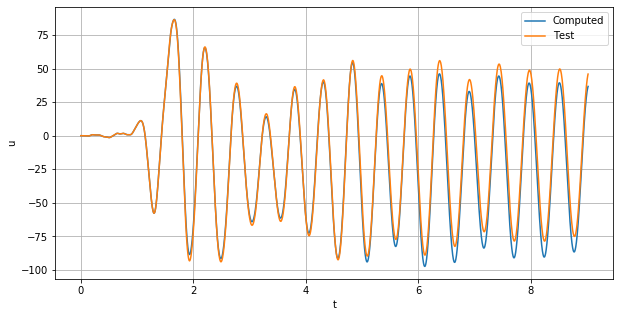

In [10]:
Test = pd.read_csv("test-3.txt", delimiter='\s+') # time [t] vs. g
Test["u"] *= 1000
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(t_arr, u_arr, label="Computed")
ax.plot(Test["t"],Test["u"], label="Test")
ax.set_xlabel("t")
ax.set_ylabel("u")
ax.grid()
ax.legend()
plt.show()